In [ ]:
#the output is a df moments with two cols, moment and type. Type indicates whether it is a monthly expenses or not 
#the number of moemnts should the number of transactions ( other than monthly expenses)
#so if you want to edit the nr transactions: edit it in this notebook

In [43]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta

import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import datetime
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
 
pd.set_option('display.width', None)
 

In [44]:

#the purpoes is to build a function that takes start_date, end_date, excpetions for weights >>> return a complete df with final weights for each hour
#this final weight will be used later to decide the number of transactions at that hour i.e. to devide the total nr and allocate it to each hour
# 

def create_hourly_dataframe(start_date, end_date, 
                            years=[], years_weights=[], 
                            months=[], months_weights=[], 
                            days=[], days_weights=[], 
                            hours=[], hours_weights=[], 
                            day_of_weeks=[], day_of_weeks_weights=[], 
                            default_weight=1, 
                           category=''):
    # Generate a date range with hourly frequency
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')

    # Create a DataFrame with the date range
    df = pd.DataFrame(date_range, columns=['datetime'])

    # Add columns for year, month, day_of_week (name), day, and hour
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day_of_week'] = df['datetime'].dt.day_name()
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['category']= category

    # Initialize weight columns with default weight
    df['year_weight'] = default_weight
    df['month_weight'] = default_weight
    df['day_weight'] = default_weight
    df['hour_weight'] = default_weight
    df['day_of_week_weight'] = default_weight
     

    # Adjust weights based on specified arguments
    if years and years_weights:
        for year, weight in zip(years, years_weights):
            df.loc[df['year'] == year, 'year_weight'] = weight

    if months and months_weights:
        for month, weight in zip(months, months_weights):
            df.loc[df['month'] == month, 'month_weight'] = weight

    if days and days_weights:
        for day, weight in zip(days, days_weights):
            df.loc[df['day'] == day, 'day_weight'] = weight

    if hours and hours_weights:
        for hour, weight in zip(hours, hours_weights):
            df.loc[df['hour'] == hour, 'hour_weight'] = weight

    if day_of_weeks and day_of_weeks_weights:
        for day_of_week, weight in zip(day_of_weeks, day_of_weeks_weights):
            df.loc[df['day_of_week'] == day_of_week, 'day_of_week_weight'] = weight

    
    df['final_weight'] = (df['year_weight'] * df['month_weight'] * 
                          df['day_weight'] * df['hour_weight'] * 
                          df['day_of_week_weight'])
    return df

# Example usage

# start_date = '2024-01-01'
# end_date = '2024-01-2'
 
# df = create_hourly_dataframe(start_date, end_date,
#                              years=[2023], years_weights=[3],
#                              months=[1], months_weights=[2],
#                              days=[1], days_weights=[3],
#                              hours=[0, 1], hours_weights=[2, 3],
#                              day_of_weeks=['Sunday', 'Tuesday'], day_of_weeks_weights=[4,8],
#                              default_weight=1)
# df





In [45]:
#takes a df with cols nr_transactions_per_hour and datetime, returns a new df of one col, moments 
#which is randomly generated moments for each hour, nr of those moments is the nr_transactions_per_hour
def generate_random_moments(df):
     
    all_times = []

    for _, row in df.iterrows():
        hour_start = pd.to_datetime(row['datetime']).replace(minute=0, second=0, microsecond=0)
        num_transactions = int(np.ceil(row['nr_transactions_per_hour']))  # round up to int

        for _ in range(num_transactions):
            random_seconds = random.randint(0, 3599)
            random_time = hour_start + timedelta(seconds=random_seconds)
            all_times.append(random_time)

    # Create a DataFrame with one column, sorted
    result_df = pd.DataFrame({'moment': sorted(all_times)})

    return result_df


# result_df = generate_random_moments(df)
# print(result_df)

In [76]:
#final_moments


#here, specify which years, months, days or hours you want to put extra weight on

start_date = '2024-01-01'
end_date = '2025-01-21'
 
hourly_df = create_hourly_dataframe(start_date, end_date,
                             years=[2024, 2025], years_weights=[2,1],
                             months=[5,6,7,12], months_weights=[2 ,2,2,3],
                             days=[1,2,3,4], days_weights=[3,2,3,2],
                             hours=[8,9,10,11,12], hours_weights=[2, 3,3,2,3],
                             day_of_weeks=['Monday', 'Friday' , 'Saturday'], day_of_weeks_weights=[2,2,2],
                             default_weight=1)

#note, this number is just an estimation, because of rounding, you will get a different final total_nr_transactions 
initial_nr_transactions=50000

unit_weight=initial_nr_transactions /  hourly_df.final_weight.sum()  
 
hourly_df ['nr_transactions_per_hour']=   unit_weight*  hourly_df ['final_weight'] 
hourly_df ['nr_transactions_per_hour']=np.ceil(hourly_df['nr_transactions_per_hour']).astype(int) 

moments =  generate_random_moments(hourly_df)
len (moments)
 


53957

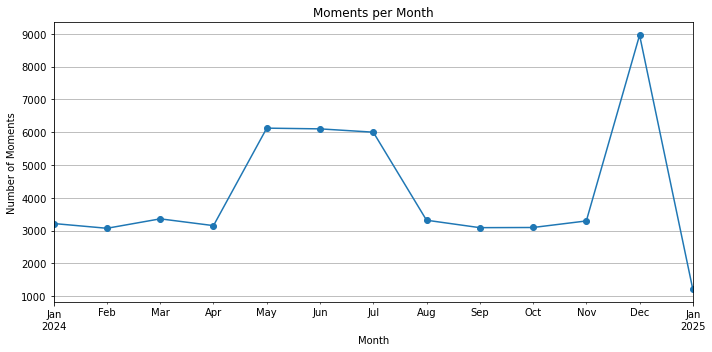

In [77]:
#plotting nr transaction per month in that period just to see the trends:
monthly_counts = moments['moment'].dt.to_period('M').value_counts().sort_index()
monthly_counts = moments.set_index('moment').resample('M').size()

plt.figure(figsize=(10, 5))
monthly_counts.plot(kind='line', marker='o')
plt.title('Moments per Month')
plt.xlabel('Month')
plt.ylabel('Number of Moments')
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
#finally: we add a new col: type: for allow for mothly payments ( rent , electricity etc..)
 
#here we are preparing the moments: for each firsd day of the month, we will choose one moment, which will have 
#the type as monthly, to pay expenses and getting salaries, for all other expenses, the type will be 'other'
# Create a column to identify the first day of each month
moments['first_day_of_month'] = moments['moment'].dt.is_month_start

# Randomly select one moment for each first day of the month
first_day_moments = moments[moments['first_day_of_month']]

# Randomly assign one 'monthly' label for each first day of the month
first_day_moments['type'] = 'monthly'
first_day_moments = first_day_moments.groupby(first_day_moments['moment'].dt.to_period('M')).sample(n=1)

# Merge the 'first_day_moments' back into the original dataframe
moments = pd.merge(moments, first_day_moments[['moment', 'type']], how='left', on='moment')

# For all other rows, assign 'other' type
moments['type'] = moments['type'].fillna('other')
 
moments = moments[['moment', 'type']]
moments.head()

C:\Users\mikda\AppData\Local\Temp\ipykernel_7364\14189587.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_day_moments['type'] = 'monthly'


,moment,type
0,2024-01-01 00:00:14,other
1,2024-01-01 00:01:32,other
2,2024-01-01 00:08:27,other
3,2024-01-01 00:10:47,other
4,2024-01-01 00:12:18,other


In [79]:
nr_people = 3000
nr_monthly_payments_categories= 6
final_nr_transactions = (len ( moments.query("type=='monthly'"))  * nr_people*nr_monthly_payments_categories ) + len ( moments.query("type!='monthly'"))
final_nr_transactions

287944

In [80]:
len ( moments.query("type!='monthly'"))

53944

In [81]:
moments.to_excel('moments.xlsx', index=False)
print('done')

done
